In [1]:
import jax.numpy as np

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm
import numpy as onp
import itertools
from functools import partial
import matplotlib.pyplot as plt

from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

/home/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


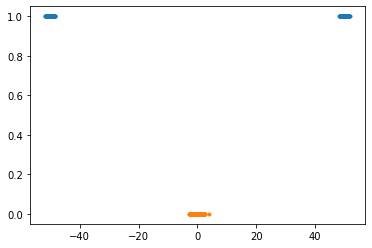

In [2]:
n = 900
n_2 = int(n / 3.0)

X1 = npr.randn(n).reshape(-1,1) + 0#50
X21 = 0.6 * npr.randn(450).reshape(-1,1) + 50
X22 =  0.6 * npr.randn(450).reshape(-1,1) - 50
# X23 =  0.6 * npr.randn(300).reshape(-1,1) - 30

X2 = np.concatenate((X22, X21), axis=0)

perm = onp.random.permutation(n)

X2 = X2[perm,:] 

plt.plot(X2.flatten(), [1] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [21]:
def data_stream(X):
    rng =  npr.RandomState(0)

    batch_size = 200
    num_batches = int(np.ceil(X.shape[0] / batch_size))
#     print(num_batches)

    num_train = X.shape[0]
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield X[batch_idx]
            
def create_network(dim, weights):
    model  = []
    for weight in weights:
        model.append(
            Dense(weight)
        )

        model.append(
            Relu
        )


    model.append(Dense(dim))

    init_random_params, predict = stax.serial(
       *model
    )
    return init_random_params, predict

In [27]:
def inner_loss(theta, batch):       
    batch_terminal_empirical = next(data_stream(X2))

    H = silvermans_rule(X2)
    
    Xt = b_forward(theta, batch)

    cross_entropy = -log_prob(Xt, batch_terminal_empirical, H)

    J = np.mean(cross_entropy)
    J = np.squeeze(J)

    return J

In [ ]:

log_prob = log_kde_pdf_per_point

dim = 1

b_forward_init, b_forward = create_network(1, [2])
opt_init_f, opt_update_f, get_params_f = optimizers.adam(1e-5)

rng = jax.random.PRNGKey(0)

_, init_params_f = b_forward_init(rng, (-1, dim))                                             
opt_state_f = opt_init_f(init_params_f)

batches_f = data_stream(X1)

loss_f = []

theta_f = get_params_f(opt_state_f)

for i in tqdm(range(1000)):
    itercount = itertools.count()

    for k in range(1):
        while True:
            batch_f =  next(batches_f)
            params = get_params_f(opt_state_f)
            gradient = grad(inner_loss)(params, batch_f)
            opt_state_f = opt_update_f(i, gradient, opt_state_f)
        params_f = get_params_f(opt_state_f)
        lossf = inner_loss(params_f, batch_f, True)
        print(f"loss f {lossf}")
    loss_f.append(lossf)